Vasmos a cargar el dataset de AirBnB descargado de [aquí](https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&q=Madrid&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imhvc3RfbGlzdGluZ3NfY291bnQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1jdXN0b20ifV0sInhBeGlzIjoiY2l0eSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6IiIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJyb29tX3R5cGUiLCJjb25maWciOnsiZGF0YXNldCI6ImFpcmJuYi1saXN0aW5ncyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuaG9zdF92ZXJpZmljYXRpb25zIjp0cnVlLCJkaXNqdW5jdGl2ZS5hbWVuaXRpZXMiOnRydWUsImRpc2p1bmN0aXZlLmZlYXR1cmVzIjp0cnVlfX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&location=16,41.38377,2.15774&basemap=jawg.streets)

![](descargar.png)

In [2]:
#install.packages("dplyr")
#install.packages('dplyr', repos = 'https://cloud.r-project.org')
library(magrittr)
library(dplyr)


library(ggplot2)
options(repr.plot.height=8,repr.plot.width=16)

In [3]:
airbnb<-read.csv('airbnb-listings.csv',sep = ';')
options(repr.plot.height=4,repr.plot.width=6,repr.plot.res = 300)

Vamos a quedarnos con las columnas de mayor interés:

'City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude'

In [4]:
airbnb <- airbnb[,c('City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude')]
airbnb |> head()

,City,Room.Type,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Square.Feet,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude
,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,Madrid,Entire home/apt,,2,1.0,0,1,50,NA,2,15,96,40.40745,-3.707995
2,Madrid,Entire home/apt,,4,1.0,1,2,50,NA,2,25,81,40.40832,-3.705006
3,Madrid,Entire home/apt,,4,1.5,1,2,77,NA,1,0,89,40.41372,-3.706823
4,Madrid,Entire home/apt,Embajadores,2,1.0,1,2,50,NA,1,20,93,40.41126,-3.697305
5,Madrid,Entire home/apt,Embajadores,5,1.0,2,4,95,NA,4,0,97,40.41256,-3.701155
6,Madrid,Entire home/apt,La Latina,4,1.0,1,2,69,NA,2,18,91,40.40791,-3.705095


Nos quedarmos solo con las entradas de Madrid para Room.Type=="Entire home/apt" y cuyo barrio (Neighbourhood) no está vacio ''
Podemos eliminar las siguientes columnas que ya no son necesarias:
"Room.Type",'City'

Llama a nuevo dataframe df_madrid.

In [5]:
df_madrid <- airbnb[airbnb$Room.Type=='Entire home/apt' & 
                    !is.na(airbnb$Neighbourhood) & 
                    airbnb$Neighbourhood != '',
                    c(-1,-2)]

df_madrid |> head()

,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Square.Feet,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude
,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
4,Embajadores,2,1,1,2,50,NA,1,20,93,40.41126,-3.697305
5,Embajadores,5,1,2,4,95,NA,4,0,97,40.41256,-3.701155
6,La Latina,4,1,1,2,69,NA,2,18,91,40.40791,-3.705095
9,Embajadores,4,1,1,2,57,NA,2,8,98,40.41162,-3.703281
10,La Latina,2,1,1,1,59,NA,1,0,95,40.40734,-3.707019
15,La Latina,14,2,3,14,120,NA,2,18,92,40.40908,-3.704744


Crea una nueva columna llamada Square.Meters a partir de Square.Feet. Recuerda que un pie cuadrado son 0.092903 metros cuadrados.

In [6]:
df_madrid$Square.Meters <- df_madrid$Square.Feet * 0.092903

df_madrid[!is.na(df_madrid$Square.Feet),] |> head(5)

,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Square.Feet,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters
,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
51,La Latina,6,2,2,2,72,592,2,20,90,40.41206,-3.709149,54.99858
148,Acacias,4,1,1,2,60,538,2,15,98,40.40513,-3.707726,49.98181
211,Malasaña,4,1,2,3,105,753,1,0,97,40.42900,-3.703498,69.95596
224,Recoletos,2,1,0,2,61,323,1,0,92,40.42800,-3.686409,30.00767
256,Malasaña,8,2,3,4,120,1184,6,0,83,40.42198,-3.705419,109.99715


¿Que porcentaje de los apartamentos no muestran los metros cuadrados? Es decir, ¿cuantos tienen NA en Square.Meters?

In [7]:
porcentaje_NA_m2 <- (df_madrid[is.na(df_madrid$Square.Meters),] |> nrow() / df_madrid |> nrow())
porcentaje_NA_m2

[1] 0.9360465

De todos los apartamentos que tienen un valor de metros cuadrados diferente de NA 
¿Que porcentaje de los apartamentos tienen 0 metros cuadrados?

In [8]:
# DF de apartamentos con m2 diferente a NA
df_madrid_noNA <- df_madrid[!is.na(df_madrid$Square.Meters),]

# Utilizando el DF anterior
porcentaje_0_m2 <- (df_madrid_noNA[df_madrid_noNA$Square.Meters == 0,] |> nrow() / df_madrid_noNA |> nrow())
porcentaje_0_m2

[1] 0.3939394

Reemplazar todos los 0m^2 por NA 

In [9]:
df_madrid[!is.na(df_madrid$Square.Meters) & df_madrid$Square.Meters == 0,] |> nrow()
df_madrid[is.na(df_madrid$Square.Meters),] |> nrow()

[1] 13

[1] 483

In [10]:
df_madrid$Square.Meters[df_madrid$Square.Meters == 0] <- NA

df_madrid[!is.na(df_madrid$Square.Meters) & df_madrid$Square.Meters == 0,] |> nrow()
df_madrid[is.na(df_madrid$Square.Meters),] |> nrow()

[1] 0

[1] 496

Son muchos, vamos a intentar crear un modelo que nos prediga cuantos son los metros cuadrados en función del resto de variables para tratar de rellenar esos NA. Pero **antes de crear el modelo** vamos a hacer:
* pintar el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más.
* crearemos una variable sintética nueva basada en la similitud entre barrios que usaremos en nuestro modelo.

Pinta el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más

Warning message:
“Removed 496 rows containing non-finite values (stat_bin).”


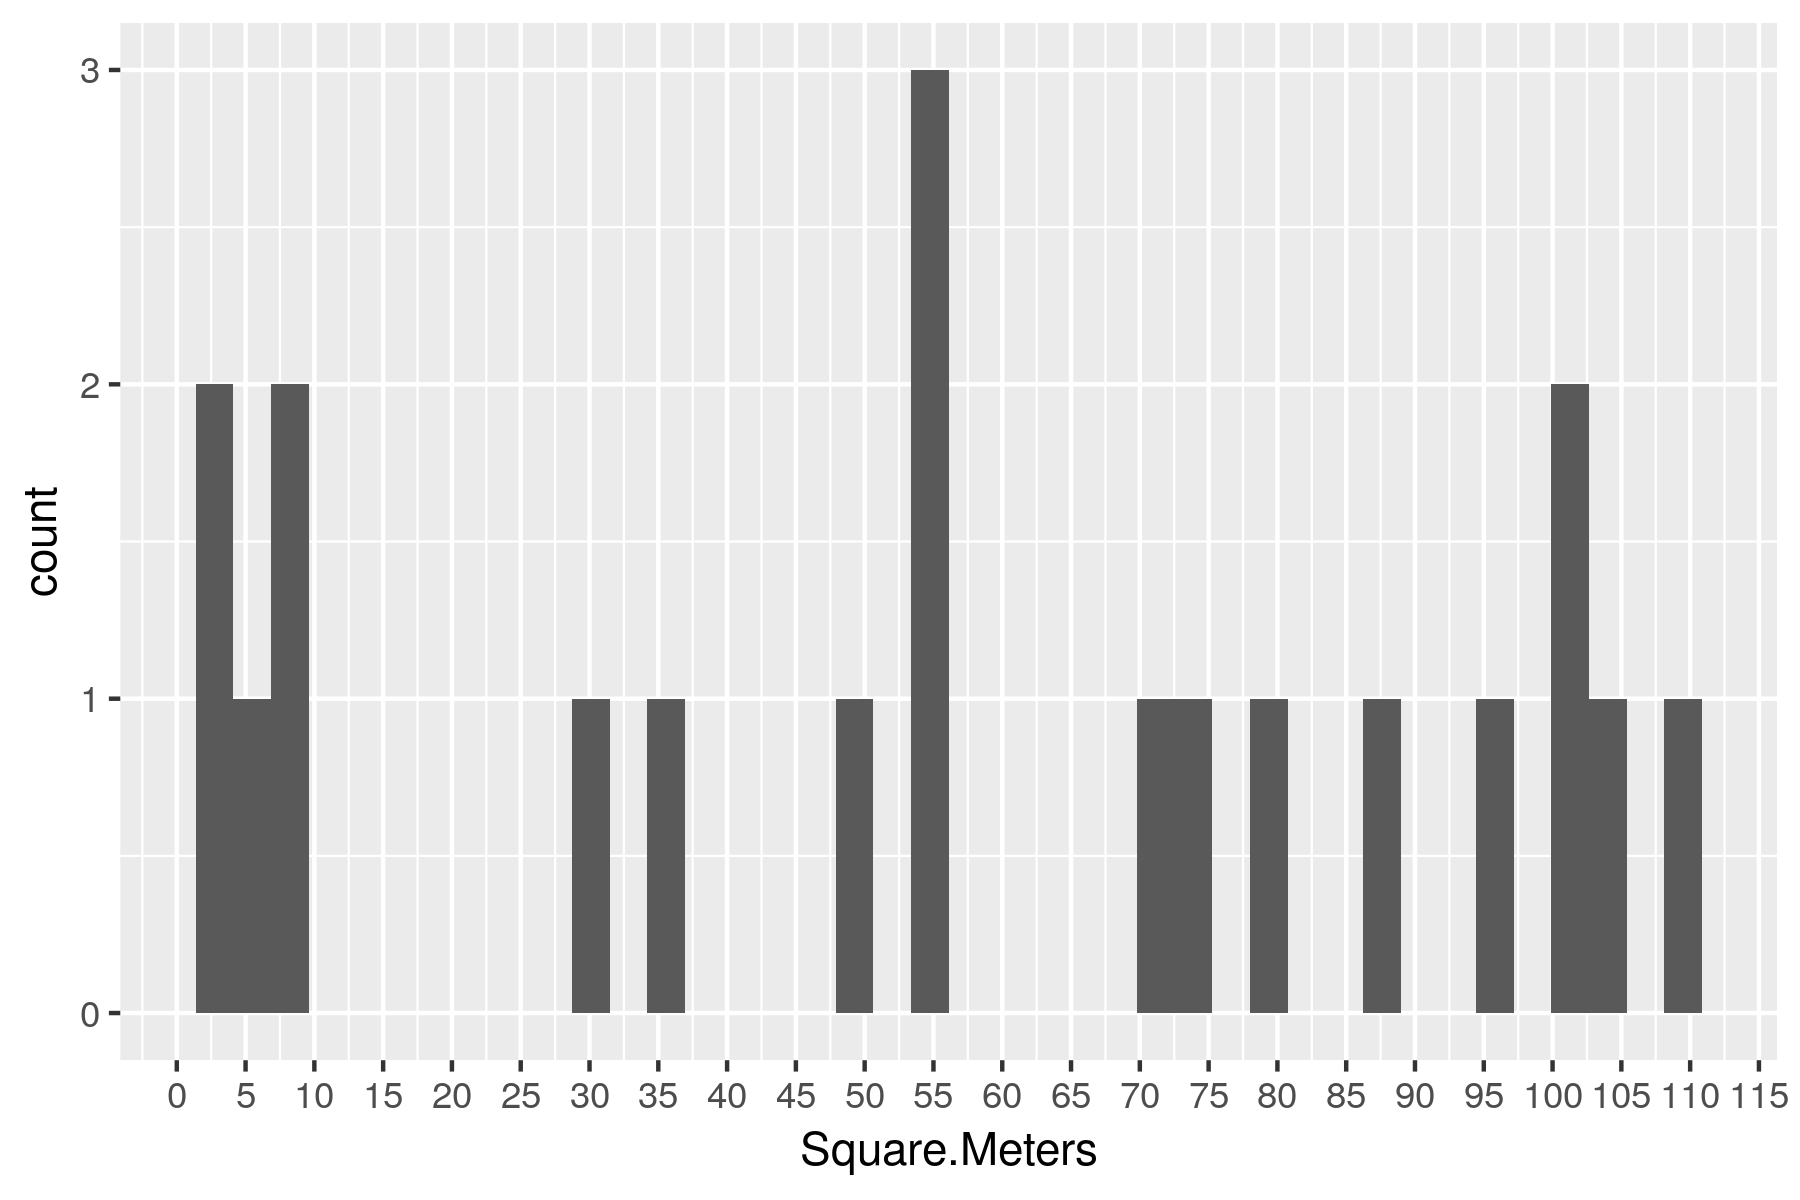

In [11]:
ggplot(data=df_madrid, aes(x=Square.Meters))+
    geom_histogram(bins=40)+
    scale_x_continuous(breaks = seq(0, 400, by = 5))

Asigna el valor NA a la columna Square.Meters de los apartamentos que tengan menos de 20 m^2

In [12]:
df_madrid$Square.Meters[df_madrid$Square.Meters < 20] <- NA

Existen varios Barrios que todas sus entradas de Square.Meters son NA, vamos a eliminar del dataset todos los pisos que pertenecen a estos barrios.

In [58]:
# Agrupo DF por barrios y cuento cuandos valores de m2 distintos a NA hay en cada barrio.
# Si no tiene ningun valor distinto a NA, ese barrio debera ser eliminado.
df_madrid |> group_by(Neighbourhood) |>
    summarise("Cantidad de pisos" = n(), "Cantidad de pisos con m2 != NA"= sum(!is.na(Square.Meters))) -> df_group_barrios

# Selecciona solo los barrios que tienen al menos un valor de m2 distinto a NA
df_barrios_sin_m2_NA <- df_group_barrios[df_group_barrios$"Cantidad de pisos con m2 != NA" > 0, "Neighbourhood"] 

# Convierte de tibble a vector
barrios_sin_m2_NA <- pull(df_barrios_sin_m2_NA,Neighbourhood)

# Selecciona del DF original, solo esos barrios.
df_madrid <- df_madrid[df_madrid$Neighbourhood %in% barrios_sin_m2_NA,]


El barrio parece ser un indicador importante para los metros cuadrados de un apartamento.

Vamos a agrupar los barrios por metros cuadrados. Podemos usar una matriz de similaridad de Tukey tal y como hicimos en el curso de estadística:

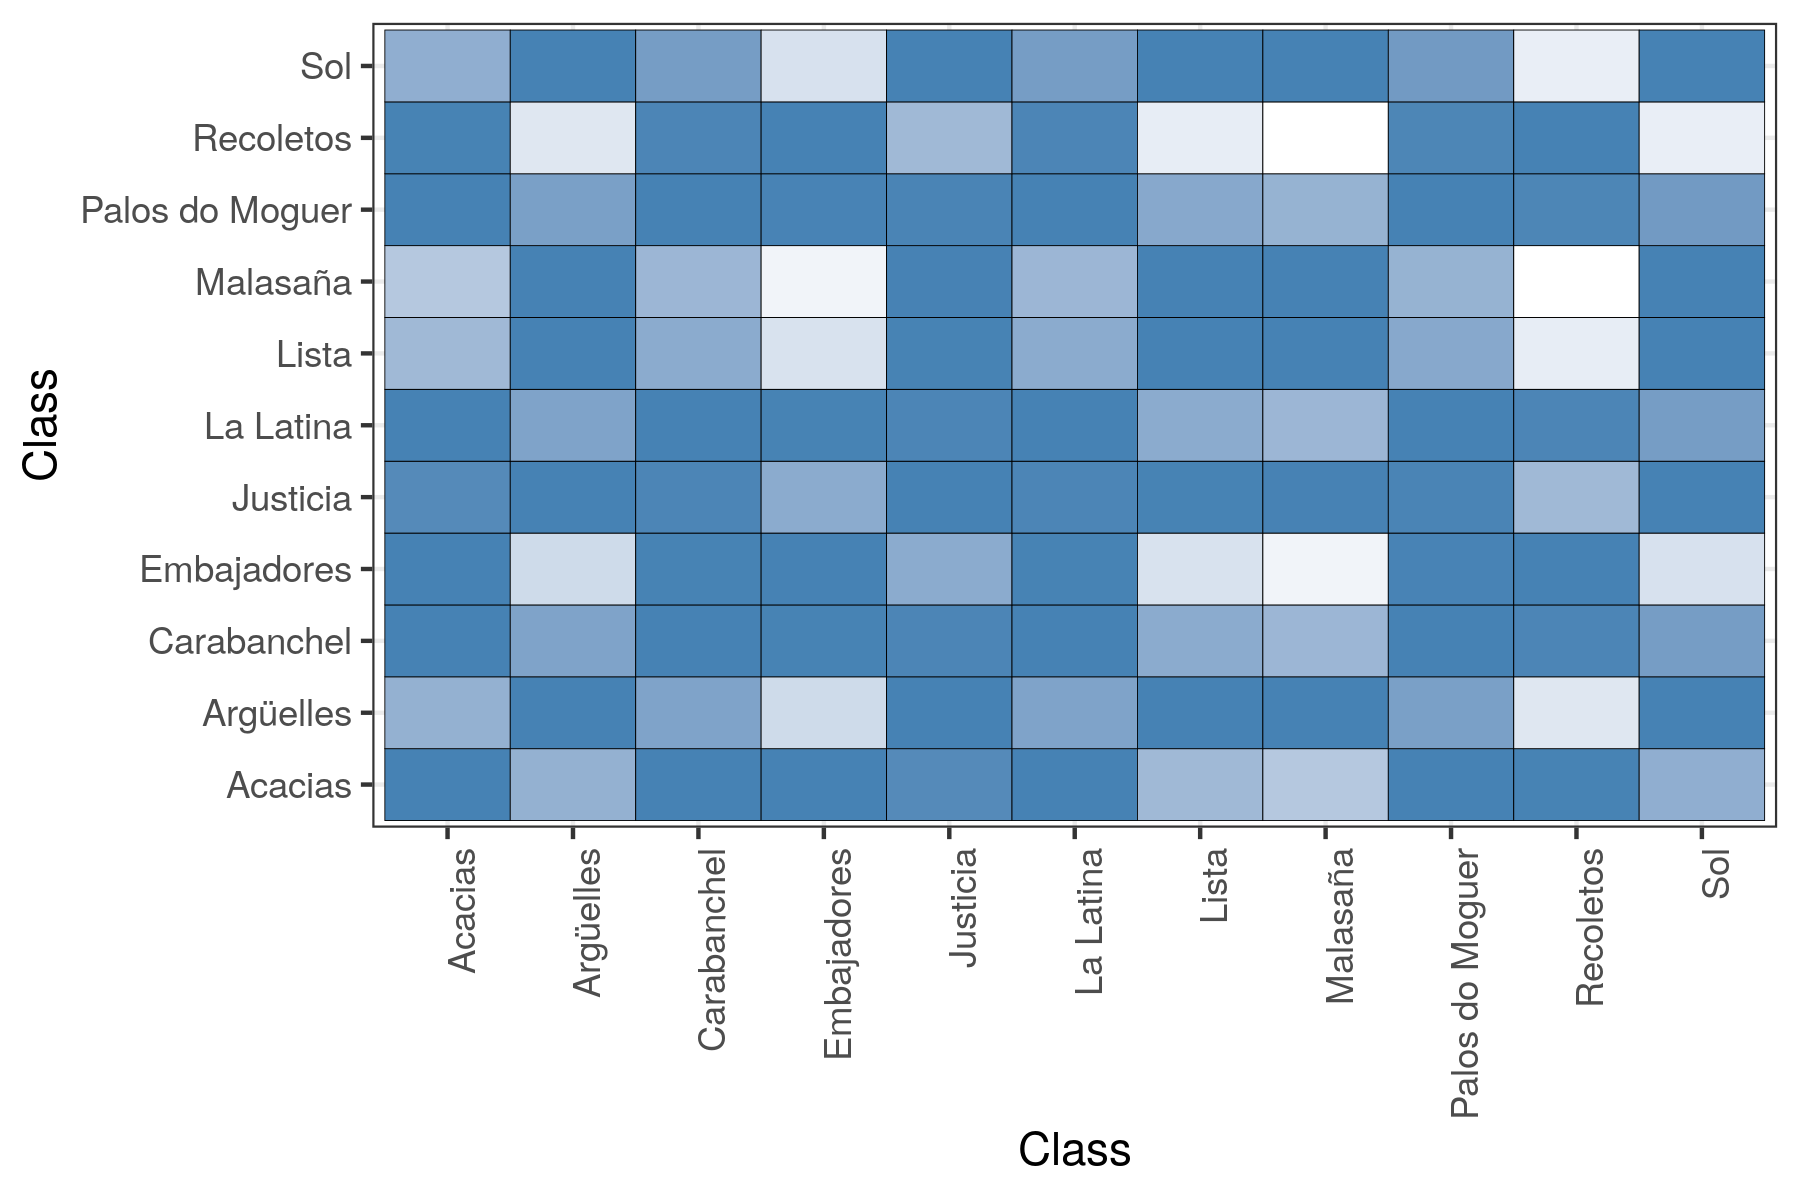

In [59]:
tky<-TukeyHSD(aov( formula=Square.Meters~Neighbourhood, data=df_madrid ))
tky.result<-data.frame(tky$Neighbourhood)
cn <-sort(unique(df_madrid$Neighbourhood))
resm <- matrix(NA, length(cn),length(cn))
rownames(resm) <- cn
colnames(resm) <- cn
resm[lower.tri(resm) ] <- round(tky.result$p.adj,4)
resm[upper.tri(resm) ] <- t(resm)[upper.tri(resm)] 
diag(resm) <- 1
library(ggplot2)
library(reshape2)
dfResm <- melt(resm)
ggplot(dfResm, aes(x=Var1, y=Var2, fill=value))+
  geom_tile(colour = "black")+
  scale_fill_gradient(low = "white",high = "steelblue")+
  ylab("Class")+xlab("Class")+theme_bw()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position="none")

Usando como variable de distancia: 1-resm
Dibuja un dendrograma de los diferentes barrios.


¿Que punto de corte sería el aconsejable?, ¿cuantos clusters aparecen?

Vamos a crear una nueva columna en el dataframe df_madrid con un nuevo identificador marcado por los clusters obtenidos. Esta columna la llamaremos neighb_id

Vamos a crear dos grupos, uno test y otro train.

Tratamos de predecir los metros cuadrados en función del resto de columnas del dataframe.

Mirad el histograma de los residuos sobre el conjunto de test para evaluar la calidad de vuestro modelo

Si tuvieramos un anuncio de un apartamento para 6 personas (Accommodates), con 1 baño, con un precio de 80€/noche y 3 habitaciones en el barrio de Sol, con 3 camas y un review de 80.
¿Cuantos metros cuadrados tendría? Si tu modelo necesita algúna variable adicional puedes inventartela dentro del rango de valores del dataset.
¿Como varía sus metros cuadrados con cada habitación adicional?

Rellenar los Square.Meters con valor NA con el estimado con el modelo anterior.

Usar PCA para encontrar el apartamento más cercano a uno dado.

Este algoritmo nos ayudaría a dado un apartamento que el algoritmo nos devolvería los 5 apartamentos más similares.


Crearemos una función tal que le pasemos un apartamento con los siguientes datos:
* Accommodates	
* Bathrooms	
* Bedrooms	
* Beds	
* Price	
* Guests.Included	
* Extra.People	
* Review.Scores.Rating	
* Latitude	
* Longitude	
* Square.Meters

y nos devuelva los 5 más similares de:

Bonus: ¿de todas las coordenadas PCA cual es la que mejor permite clasificar por id de barrio?

¿Por qué?